# Section 1: CNN Model

### Block 1: Environment Setup & Library Imports
**What it does:**
> Configures TensorFlow logging to show only warnings and errors, then imports all necessary libraries and modules for image loading/preprocessing, model construction/training, data splitting and cross-validation, plotting, and performance evaluation.

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

### Block 2: Data Paths & Class Distribution
**What it does:**
> Sets the file paths for training and testing datasets, dynamically detects class labels from the training directory, and prints out the number of images per class (and overall totals) for both splits.

In [2]:
TRAIN_DIR = r"C:\Users\kastr\PycharmProjects\helloWorld\data\brain_tumors\Brain Tumor Data(1)\Brain Tumor Data\Brain Tumor data\Brain Tumor data\Training"
TEST_DIR  = r"C:\Users\kastr\PycharmProjects\helloWorld\data\brain_tumors\Brain Tumor Data(1)\Brain Tumor Data\Brain Tumor data\Brain Tumor data\Testing"
CLASSES = ["no_tumor", "pituitary", "meningioma", "glioma"]

CLASSES = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])
print("Detected classes:", CLASSES)

for split_dir in [TRAIN_DIR, TEST_DIR]:
    print(f"\n=== {os.path.basename(split_dir).upper()} ===")
    total = 0
    for cls in CLASSES:
        n = len(glob.glob(os.path.join(split_dir, cls, "*.jpg")))
        total += n
        print(f"  {cls:12s}: {n:4d}")
    print(f"  → TOTAL: {total}")

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

=== TRAINING ===
  glioma      : 1321
  meningioma  : 1339
  notumor     : 1595
  pituitary   : 1457
  → TOTAL: 5712

=== TESTING ===
  glioma      :  300
  meningioma  :  306
  notumor     :  405
  pituitary   :  300
  → TOTAL: 1311


### Block 3: Hyperparameter Setup
**What it does:**
> Defines key parameters for the workflow image resize dimensions, batch size for training, number of folds for stratified cross-validation, and the epoch counts for both CV runs and the final model training.

In [3]:
IMG_SIZE     = (150, 150)  # used by loader + model input
BATCH        = 32          # used in model.fit(...)
K_FOLDS      = 5           # used by StratifiedKFold
EPOCHS_CV    = 5           # epochs per fold during Cross Validation
EPOCHS_FINAL = 10

### Block 4: Sample Image Visualization
**What it does:**
> Loads one representative image from each class in the training set, resizes it to the specified dimensions and converts it to grayscale, then displays these samples side by side with their class names as titles.

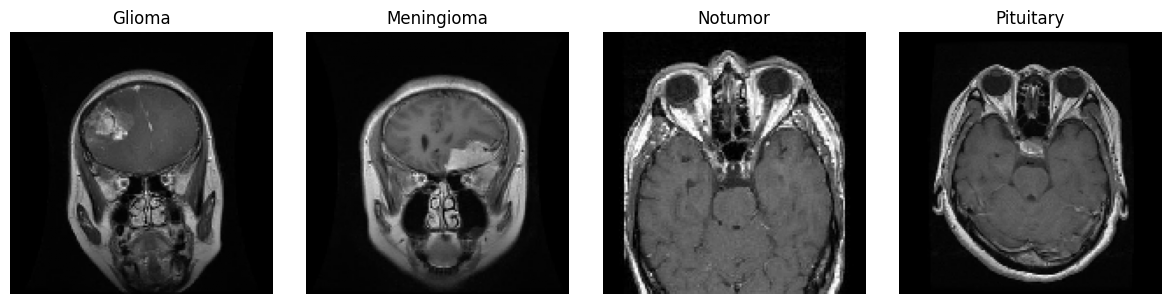

In [4]:
fig, axes = plt.subplots(1, len(CLASSES),
                         figsize=(len(CLASSES)*3, 3))
for i, cls in enumerate(CLASSES):
    img_path = glob.glob(os.path.join(TRAIN_DIR, cls, "*.jpg"))[0]
    img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(cls.replace("_", " ").capitalize(), fontsize=12)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

### Block 5: Data Loading & Normalization
**What it does:**
> Defines and uses a function to read every image file from each class directory, resize to the target dimensions, convert to grayscale arrays, scale each image’s pixel values to [0,1], and assemble the data into NumPy tensors with one-hot encoded labels for both training and testing sets.

In [5]:
def load_and_norm_all(folder):
    X, y = [], []
    for idx, cls in enumerate(CLASSES):
        pat = os.path.join(folder, cls, "*.jpg")
        for path in glob.glob(pat):
            img = load_img(path, target_size=IMG_SIZE, color_mode="grayscale")
            arr = img_to_array(img).squeeze()   # shape → (H, W)
            mi, ma = arr.min(), arr.max()
            arr = (arr - mi) / (ma - mi + 1e-8)

            X.append(arr)
            y.append(idx)
    X = np.array(X)[..., np.newaxis]   # (N, H, W, 1)
    y = to_categorical(y, num_classes=len(CLASSES))
    return X, y

print("Loading & normalizing TRAINING data...")
X_train, y_train = load_and_norm_all(TRAIN_DIR)
print("Loading & normalizing TESTING data...")
X_test,  y_test  = load_and_norm_all(TEST_DIR)

Loading & normalizing TRAINING data...
Loading & normalizing TESTING data...


### Block 6: Original vs. Normalized Image Comparison
**What it does:**
> Illustrates one sample per class from the training set, computes its normalized pixel array, and displays the original and normalized grayscale images side by side in a grid to illustrate the effect of normalization.

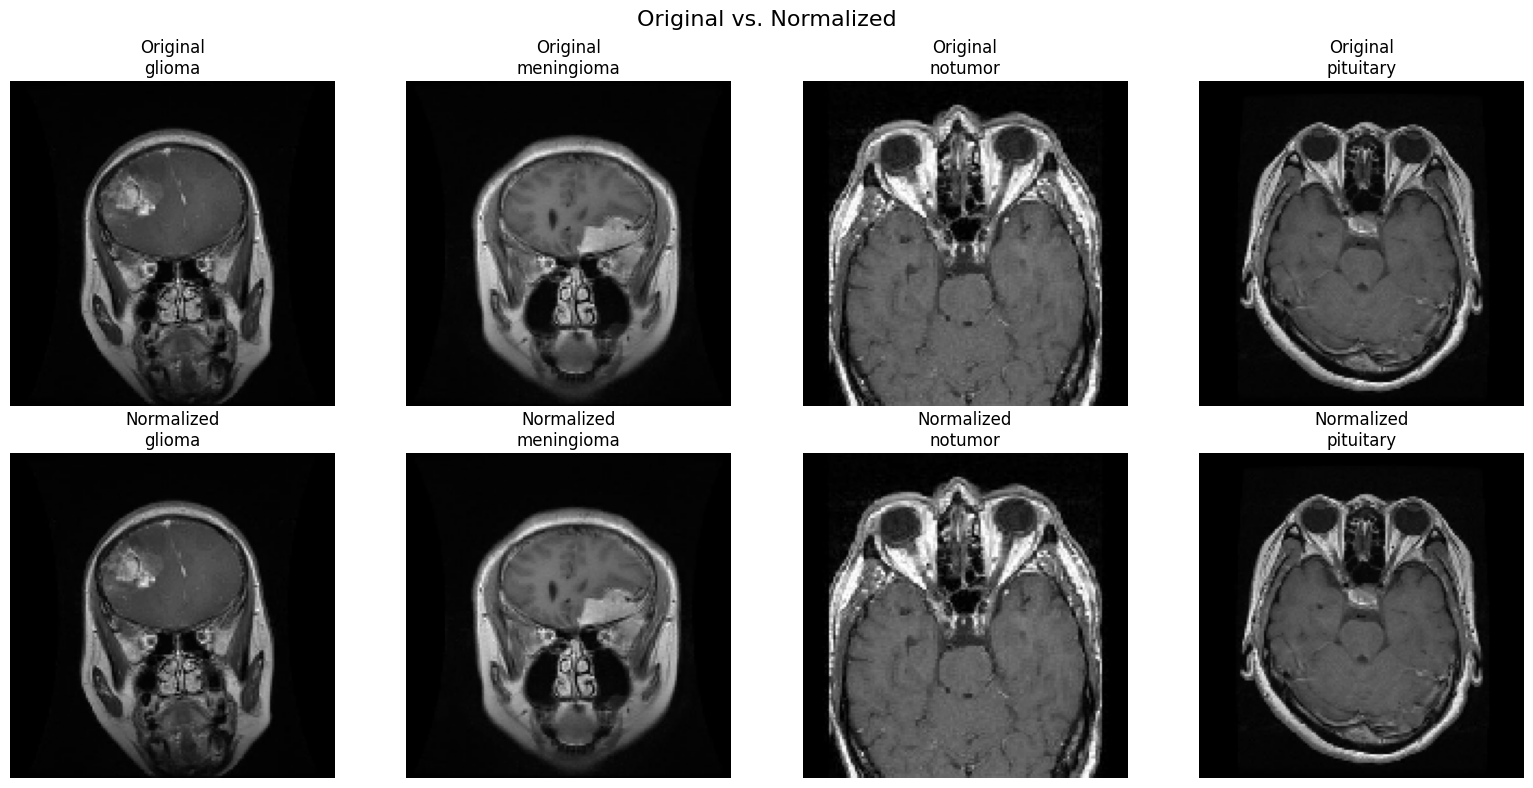

In [6]:
fig, axes = plt.subplots(2, len(CLASSES), figsize=(4*len(CLASSES), 8))
for i, cls in enumerate(CLASSES):
    # pick one example image per class
    ex_path = glob.glob(os.path.join(TRAIN_DIR, cls, "*.jpg"))[0]
    orig = img_to_array(load_img(ex_path, target_size=IMG_SIZE, color_mode="grayscale")).squeeze()
    mi, ma = orig.min(), orig.max()
    norm = (orig - mi) / (ma - mi + 1e-8)

    axes[0, i].imshow(orig, cmap="gray")
    axes[0, i].set_title(f"Original\n{cls}")
    axes[0, i].axis("off")

    axes[1, i].imshow(norm, cmap="gray")
    axes[1, i].set_title(f"Normalized\n{cls}")
    axes[1, i].axis("off")

plt.suptitle("Original vs. Normalized", fontsize=16)
plt.tight_layout()
plt.show()

### Block 7: CNN Model Definition & Stratified k-Fold Cross-Validation
**What it does:**
> Defines and compiles the convolutional neural network architecture, sets up a stratified K-fold splitter on the training labels, then for each fold builds and trains the model for the specified number of epochs, recording the best validation accuracy per fold—and finally reports the cross-validated mean and standard deviation of validation accuracy.

In [11]:
def build_model(img_size=IMG_SIZE, n_classes=len(CLASSES)):
    m = models.Sequential([
        layers.Input(shape=(img_size[0], img_size[1], 1)),
        layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"), layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation="softmax")
    ])
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return m

y_int = np.argmax(y_train, axis=1)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)

fold_best = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_int), 1):
    print(f"\n--- Fold {fold}/{K_FOLDS} ---")
    m = build_model()
    h = m.fit(X_train[tr_idx], y_train[tr_idx],
              epochs=EPOCHS_CV, batch_size=BATCH,
              validation_data=(X_train[val_idx], y_train[val_idx]),
              verbose=0)
    best_va = float(np.max(h.history["val_accuracy"]))
    print(f"Best val acc: {best_va:.4f}")
    fold_best.append(best_va)

print(f"\nCV val accuracy: mean={np.mean(fold_best):.4f} ± {np.std(fold_best):.4f}")


--- Fold 1/5 ---
Best val acc: 0.9186

--- Fold 2/5 ---
Best val acc: 0.9423

--- Fold 3/5 ---
Best val acc: 0.9238

--- Fold 4/5 ---
Best val acc: 0.9282

--- Fold 5/5 ---
Best val acc: 0.8940

CV val accuracy: mean=0.9214 ± 0.0158


### Block 8: Preliminary Full-Training Run Without Hold-Out
**What it does:**
> Trains the CNN on the entire training dataset for the specified number of epochs, then evaluates its performance on the held-out test set and plots only the training accuracy over epochs. This experiment establishes a baseline by training on all available samples without reserving any data for validation monitoring. Comparing its test accuracy and learning curve to the later “monitor‐split” version quantifies the impact of including a small validation hold-out during training on generalization and overfitting control.


In [12]:
final_model = build_model()
hist_final = final_model.fit(
    X_train, y_train,
    epochs=EPOCHS_FINAL, batch_size=BATCH, verbose=1
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 346ms/step - accuracy: 0.5971 - loss: 0.9407
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.8203 - loss: 0.4619
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.8790 - loss: 0.3165
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.9090 - loss: 0.2253
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 420ms/step - accuracy: 0.9229 - loss: 0.2190
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 329ms/step - accuracy: 0.9464 - loss: 0.1450
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 298ms/step - accuracy: 0.9606 - loss: 0.1173
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.9656 - loss: 0.1018
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 370ms/step - accuracy: 0.9677 - loss: 0.0914
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 57s 318ms/step - accuracy: 0.9750 - loss: 0.0711


In [13]:
loss, acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Held-out Test Accuracy: {acc:.2%}")

Held-out Test Accuracy: 96.49%


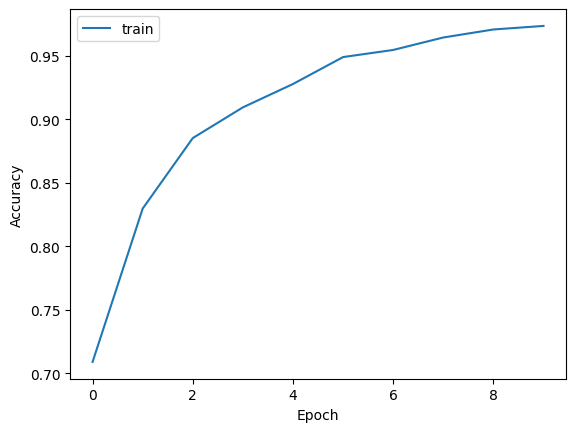

In [14]:
plt.plot(hist_final.history["accuracy"], label="train")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

### Block 9: Final Model Training with Hold-Out Validation
**What it does:**
> After cross-validation, we perform a final training run using almost all the available data but still hold out a small validation (monitor) set. We stratify the split to preserve class proportions, and fix a random seed for reproducibility. Calling `build_model()` anew gives us a fresh network that hasn’t seen any validation data. The `.summary()` lets us inspect layer shapes and parameter counts—essential for understanding model capacity and diagnosing potential overfitting. During `.fit()`, we train in mini-batches (size defined by `BATCH`) over multiple epochs (`EPOCHS_FINAL`), shuffling between epochs to break up any order biases. Supplying `validation_data` at each epoch allows us to monitor loss and accuracy on unseen samples, helping us decide when to stop or adjust hyperparameters.

In [32]:
y_int = np.argmax(y_train, axis=1)
X_tr, X_mon, y_tr, y_mon = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_int, random_state=42
)
EPOCHS_FINAL = 10
final_model = build_model()
final_model.summary()
hist_final = final_model.fit(
    X_tr, y_tr,
    epochs=EPOCHS_FINAL, batch_size=BATCH,
    validation_data=(X_mon, y_mon),
    shuffle=True, verbose=1
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,292 (18.42 MB)

 Trainable params: 4,828,292 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 342ms/step - accuracy: 0.5833 - loss: 0.9639 - val_accuracy: 0.8182 - val_loss: 0.4370
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 365ms/step - accuracy: 0.8314 - loss: 0.4426 - val_accuracy: 0.8427 - val_loss: 0.3678
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.8771 - loss: 0.3352 - val_accuracy: 0.8671 - val_loss: 0.3072
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - accuracy: 0.9078 - loss: 0.2391 - val_accuracy: 0.9073 - val_loss: 0.2549
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 0.9216 - loss: 0.1991 - val_accuracy: 0.9248 - val_loss: 0.2178
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 56s 350ms/step - accuracy: 0.9546 - loss: 0.1206 - val_accuracy: 0.9423 - val_loss: 0.1887
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 69s 426ms/step - accuracy: 0.9591 - loss: 0.1074 - val_accuracy: 0.9406 - val_loss: 0.2067
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 87s 534ms/step - accuracy: 0.9742 - loss: 0

### Block 10: Test Set Evaluation
**What it does:**
> Runs the trained CNN on the held‐out test set to compute the final loss and accuracy metrics, then prints out the test accuracy as a percentage.

In [33]:
loss, acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Held-out Test Accuracy (monitor split run): {acc:.2%}")

Held-out Test Accuracy (monitor split run): 96.34%


### Block 11: Performance Metrics Reporting & Overfitting Detection
**What it does:**
> Computes and prints your final training and validation accuracies, then iterates through each epoch to report both train and val accuracy per epoch. It also finds which epoch yielded the highest validation accuracy and issues a warning if the gap between training and validation acc exceeds a threshold.

**Why we do this:**
>The calculation of final training and validation accuracies provides an objective assessment of model fit on the training set and its predictive performance on unseen data.Documenting accuracy at each epoch and determining which epoch achieved peak validation performance yields critical insights into training progression and guides selection of the most effective model state. Analyzing the magnitude of the discrepancy between training and validation accuracies serves as a diagnostic for overfitting, indicating when stronger regularization strategies or expanded data are warranted.

In [35]:
final_train_acc = hist_final.history["accuracy"][-1]
final_val_acc = hist_final.history["val_accuracy"][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
for epoch in range(len(hist_final.history["accuracy"])):
    train_acc = hist_final.history["accuracy"][epoch]
    val_acc = hist_final.history["val_accuracy"][epoch]
    print(f"Epoch {epoch+1:2d}: Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f}")
best_epoch = np.argmax(hist_final.history["val_accuracy"]) + 1
best_val = np.max(hist_final.history["val_accuracy"])
print(f"Best validation accuracy: {best_val:.4f} at epoch {best_epoch}")
if final_val_acc < final_train_acc - 0.05:
    print("Warning: Possible overfitting detected.")

Final Training Accuracy: 0.9798
Final Validation Accuracy: 0.9476
Epoch  1: Train Acc = 0.7043 | Val Acc = 0.8182
Epoch  2: Train Acc = 0.8461 | Val Acc = 0.8427
Epoch  3: Train Acc = 0.8854 | Val Acc = 0.8671
Epoch  4: Train Acc = 0.9142 | Val Acc = 0.9073
Epoch  5: Train Acc = 0.9276 | Val Acc = 0.9248
Epoch  6: Train Acc = 0.9566 | Val Acc = 0.9423
Epoch  7: Train Acc = 0.9619 | Val Acc = 0.9406
Epoch  8: Train Acc = 0.9722 | Val Acc = 0.9510
Epoch  9: Train Acc = 0.9749 | Val Acc = 0.9423
Epoch 10: Train Acc = 0.9798 | Val Acc = 0.9476
Best validation accuracy: 0.9510 at epoch 8


### Block 12: Test Set Evaluation & Learning Curve Visualization
**What it does:**
> Evaluates the final trained model on the held-out test set to report its accuracy, then plots both training and validation accuracy over all epochs to visualize learning dynamics and assess generalization.


Held-out Test Accuracy (monitor split run): 96.34%


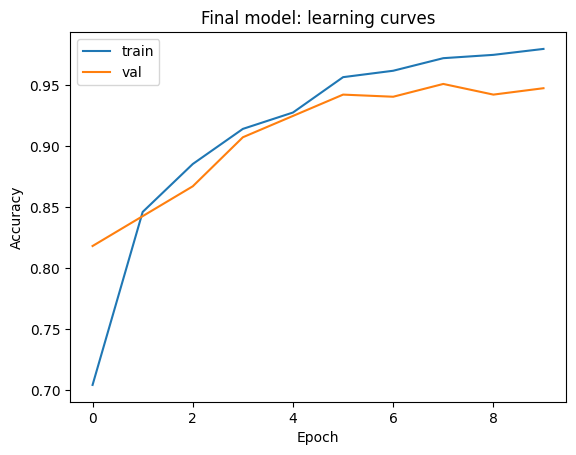

In [36]:
loss, acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Held-out Test Accuracy (monitor split run): {acc:.2%}")
plt.plot(hist_final.history["accuracy"], label="train")
plt.plot(hist_final.history["val_accuracy"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Final model: learning curves")
plt.legend(); plt.show()

### Block 13: Training & Validation Loss Visualization
**What it does:**
> Plots the loss values for both the training and validation sets across all epochs, enabling assessment of convergence behavior and detection of underfitting or overfitting.


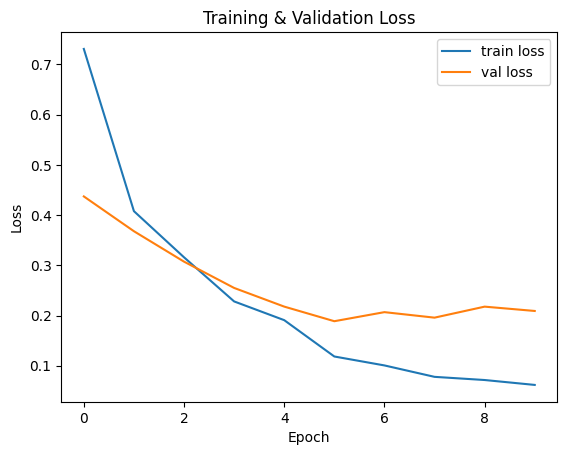

In [37]:
plt.plot(hist_final.history["loss"], label="train loss")
if "val_loss" in hist_final.history:
    plt.plot(hist_final.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.show()

### Block 14: Confusion Matrix Visualization
**What it does:**
> Generates model predictions on the test set, computes the confusion matrix to compare true versus predicted class labels, and renders an annotated heatmap to highlight per-class accuracy and misclassification patterns.


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


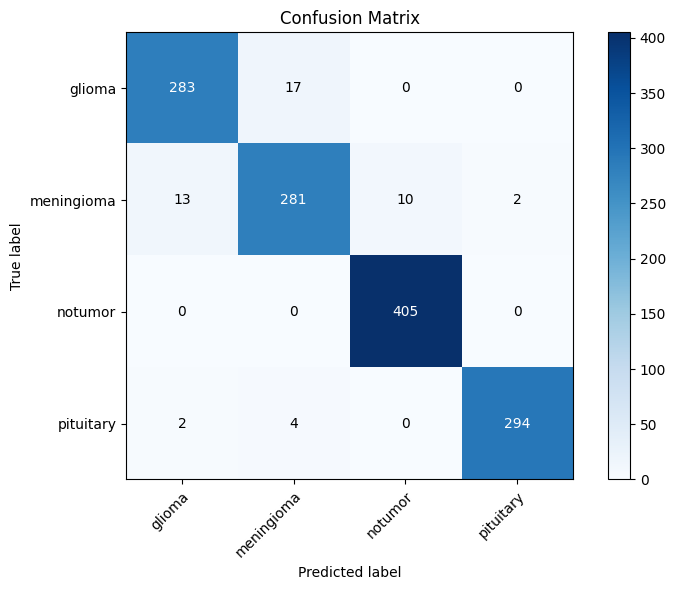

In [38]:
y_pred = np.argmax(final_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(CLASSES)),
    yticks=np.arange(len(CLASSES)),
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:d}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

### Block 15: Most Frequent Misclassification Detection
**What it does:**
> Zeros out the diagonal of the confusion matrix to ignore correct predictions, then identifies and prints the true-to-predicted class pair with the highest off-diagonal count along with the number of occurrences.


In [39]:
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Find max misclassification (i → j)
i, j = np.unravel_index(np.argmax(cm_no_diag), cm_no_diag.shape)
print(f"Most misclassified: {CLASSES[i]} → {CLASSES[j]} ({cm_no_diag[i, j]} times)")

Most misclassified: glioma → meningioma (17 times)


### Block 16: Misclassification Examples Visualization
**What it does:**
> Selects up to four test images where the true label is “meningioma” but the model predicted “glioma,” and displays them side by side to visually inspect common failure cases.


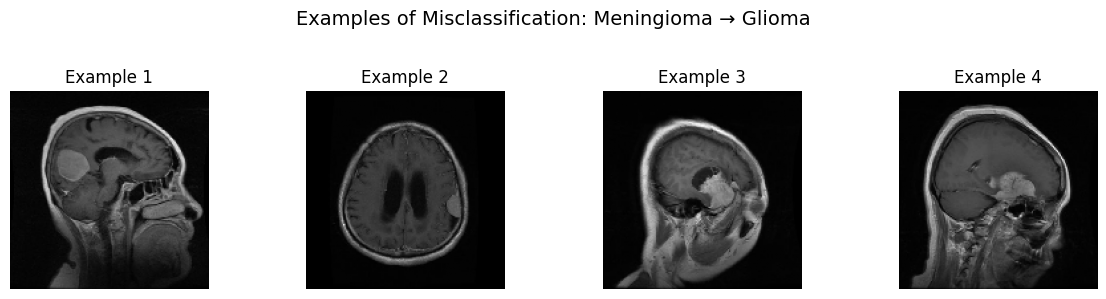

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle("Examples of Misclassification: Meningioma → Glioma", fontsize=14)

count = 0
for i in range(len(y_true)):
    if y_true[i] == CLASSES.index("meningioma") and y_pred[i] == CLASSES.index("glioma"):
        img = X_test[i].squeeze()
        axes[count].imshow(img, cmap='gray')
        axes[count].axis("off")
        axes[count].set_title(f"Example {count+1}")
        count += 1
        if count == 4:
            break

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### Block 17: Misclassification Confidence Inspection
**What it does:**
> Computes class probabilities for all test samples, identifies indices where predictions diverge from the true labels, and prints the true class, predicted class, and associated confidence for the first five misclassified examples. Examining the model’s confidence on its errors reveals whether misclassifications arise from genuinely ambiguous inputs (low confidence) or from confidently incorrect predictions, which can indicate systematic biases or feature overlaps that warrant further investigation.


In [41]:
probs = final_model.predict(X_test)
wrong_idx = np.where(y_pred != y_true)[0]
for idx in wrong_idx[:5]:  # show first 5
    print(f"True: {CLASSES[y_true[idx]]}, Pred: {CLASSES[y_pred[idx]]}, Confidence: {np.max(probs[idx]):.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
True: glioma, Pred: meningioma, Confidence: 0.96
True: glioma, Pred: meningioma, Confidence: 0.98
True: glioma, Pred: meningioma, Confidence: 1.00
True: glioma, Pred: meningioma, Confidence: 0.68
True: glioma, Pred: meningioma, Confidence: 0.82


# Section 2: Transfer Learning Model

### **Block 1: Imports & Settings**
What it does:

Brings in all the Python libraries we need—file I/O (os, glob), image handling (cv2 or PIL), numerical arrays (numpy), plotting (matplotlib, seaborn), deep‐learning frameworks (tensorflow.keras), and evaluation tools (sklearn).
Sets up some global constants (paths, image dimensions, batch size, epochs) so you can tweak them in one place.
Why it matters:

“why EfficientNetB0?”—it’s a modern, parameter-efficient model that often outperforms older ones on many vision tasks.
The log-level reduction just silences verbose GPU/device messages.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

from sklearn.model_selection import train_test_split
from sklearn.metrics        import confusion_matrix

# Paths & hyperparameters
TRAIN_DIR  = r'/Users/Phillip/Downloads/archive/Brain Tumor Data(1)/Brain Tumor Data/Brain Tumor data/Brain Tumor data/Training'
TEST_DIR   = r'/Users/Phillip/Downloads/archive/Brain Tumor Data(1)/Brain Tumor Data/Brain Tumor data/Brain Tumor data/Testing'
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 10


### **Block 2: Auto-detect Class Names**
What it does:

Reads the subfolders inside TRAIN_DIR (one per tumor type) and sorts them alphabetically.
Builds CLASSES = ['glioma','meningioma','notumor','pituitary'] automatically.
Why it matters:

Makes your code data-driven: if you add a new class folder, it just picks it up.
You can answer questions about extensibility (adding new tumor types).

In [5]:
CLASSES = sorted(
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
)
print("Detected classes:", CLASSES)


Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### **Block 3: Count & List a Few Files Per Class**
What it does:

For both training and test directories, counts how many images each class has.
Prints the first two filenames for sanity checking.
Why it matters:

Verifies you don’t have missing folders or zero images by mistake.
Helps spot class imbalance early (e.g. “notumor” might have more samples).

In [6]:
for split_dir in (TRAIN_DIR, TEST_DIR):
    print(f"\n=== {os.path.basename(split_dir).upper()} SET ===")
    total = 0
    for cls in CLASSES:
        pattern = os.path.join(split_dir, cls, "*.jpg")
        files = glob.glob(pattern)
        total += len(files)
        print(f"  {cls:12s}: {len(files):4d} images")
        for p in files[:2]:
            print(f"     • {os.path.basename(p)}")
    print(f"  → TOTAL: {total} images")



=== TRAINING SET ===
  glioma      : 1321 images
     • Tr-gl_1135.jpg
     • Tr-gl_0559.jpg
  meningioma  : 1339 images
     • Tr-me_0368.jpg
     • Tr-me_1076.jpg
  notumor     : 1595 images
     • Tr-no_0798.jpg
     • Tr-no_1486.jpg
  pituitary   : 1457 images
     • Tr-pi_0505.jpg
     • Tr-pi_0263.jpg
  → TOTAL: 5712 images

=== TESTING SET ===
  glioma      :  300 images
     • Te-gl_0284.jpg
     • Te-gl_0290.jpg
  meningioma  :  306 images
     • Te-me_0304.jpg
     • Te-me_0106.jpg
  notumor     :  405 images
     • Te-no_0051.jpg
     • Te-no_0045.jpg
  pituitary   :  300 images
     • Te-pi_0233.jpg
     • Te-pi_0227.jpg
  → TOTAL: 1311 images


### **Block 4: Plot One Example Per Class (Original → Equalized)**
What it does:

Displays a grid: top row raw grayscale MRI, bottom row histogram-equalized version, one column per class.
Why it matters:

Shows visually how equalization enhances contrast of darker regions (tumor tissue).
Preempts “why equalize?” questions: it standardizes intensity distributions so your CNN sees more uniform inputs.

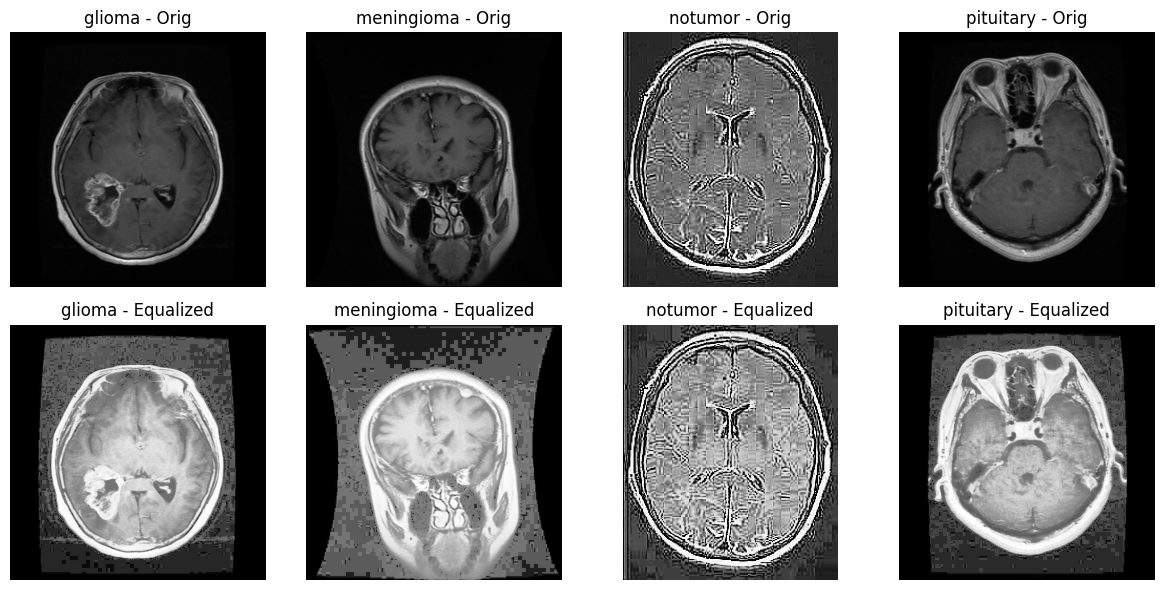

In [7]:
fig, axes = plt.subplots(2, len(CLASSES),
                         figsize=(len(CLASSES)*3, 6))
for i, cls in enumerate(CLASSES):
    # original grayscale
    p = glob.glob(os.path.join(TRAIN_DIR, cls, "*.jpg"))[0]
    orig = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    eq   = cv2.equalizeHist(orig)
    for row, img in enumerate((orig, eq)):
        axes[row, i].imshow(img, cmap='gray')
        axes[row, i].set_title(f"{cls} - {'Orig' if row==0 else 'Equalized'}")
        axes[row, i].axis('off')
plt.tight_layout()
plt.show()


### **Block 5: Load & Preprocess Functions**
What it does:

load_and_preprocess_cnn: yields an (N,224,224,1) array of min-max normalized equalized grayscale images + one-hot labels.
load_and_preprocess_tl: yields an (N,224,224,3) array ready for EfficientNetB0’s preprocess_input.
Why it matters:

Encapsulates two distinct pipelines—grayscale for your custom CNN vs. 3-channel for TL.
Ensures every image gets the same fixed shape so batching works.

In [11]:
from PIL import ImageOps

def load_and_preprocess_cnn(folder):
    """
    Grayscale CNN pipeline:
     - load as PIL grayscale
     - equalize histogram
     - resize to IMG_SIZE
     - min–max normalize per image → [0,1]
     - expand to (H,W,1)
    """
    X, y = [], []
    for idx, cls in enumerate(CLASSES):
        for p in glob.glob(os.path.join(folder, cls, "*.jpg")):
            # 1) Load & equalize
            pil = load_img(p, color_mode="grayscale")
            eq  = ImageOps.equalize(pil)
            # 2) Resize
            eq  = eq.resize(IMG_SIZE)
            # 3) To NumPy array
            arr = np.array(eq, dtype="float32")
            # 4) Min–max normalize
            mi, ma = arr.min(), arr.max()
            norm   = (arr - mi) / (ma - mi + 1e-8)
            # 5) Append with channel dim
            X.append(norm[..., np.newaxis])
            y.append(idx)

    X = np.stack(X, axis=0)  # shape → (N, H, W, 1)
    y = to_categorical(y, num_classes=len(CLASSES))
    return X, y

def load_and_preprocess_tl(folder):
    """
    Transfer-Learning pipeline (EfficientNetB0):
     - load as PIL grayscale
     - equalize histogram
     - resize to IMG_SIZE
     - stack into 3 identical channels
     - apply EfficientNetB0 preprocess_input
    """
    X, y = [], []
    for idx, cls in enumerate(CLASSES):
        for p in glob.glob(os.path.join(folder, cls, "*.jpg")):
            pil = load_img(p, color_mode="grayscale")
            eq  = ImageOps.equalize(pil)
            eq  = eq.resize(IMG_SIZE)
            arr = np.array(eq, dtype="float32")
            rgb = np.stack([arr, arr, arr], axis=-1)  # shape → (H, W, 3)
            X.append(effnet_preprocess(rgb))
            y.append(idx)

    X = np.stack(X, axis=0)  # shape → (N, H, W, 3)
    y = to_categorical(y, num_classes=len(CLASSES))
    return X, y


### **Block 6: Load TRAIN & TEST Data**
What it does:

Calls those two functions on your folders, loading everything into memory.
Why it matters:

You’ll mention memory trade-offs (“we have ≈5,000 images × 224² floats, so <1 GB RAM”).
Clarifies that training and testing come from disjoint sets.

In [12]:
print("Loading CNN data…")
X_cnn_train, y_cnn_train = load_and_preprocess_cnn(TRAIN_DIR)
X_cnn_test,  y_cnn_test  = load_and_preprocess_cnn(TEST_DIR)

print("Loading TL data…")
X_tl_train, y_tl_train = load_and_preprocess_tl(TRAIN_DIR)
X_tl_test,  y_tl_test  = load_and_preprocess_tl(TEST_DIR)


Loading CNN data…
Loading TL data…


### **Block 7: Split Off a Validation Set**
What it does:

Reserves 20% of your training set for validation, keeping class proportions the same (via stratify).
Why it matters:

Validation set is used for early stopping and hyperparameter tuning—not touched by the final test.

In [13]:
# CNN split
X_cnn_train, X_cnn_val, y_cnn_train, y_cnn_val = train_test_split(
    X_cnn_train, y_cnn_train,
    test_size=0.2, stratify=y_cnn_train, random_state=42)

# TL split
X_tl_train, X_tl_val, y_tl_train, y_tl_val = train_test_split(
    X_tl_train, y_tl_train,
    test_size=0.2, stratify=y_tl_train, random_state=42)

print("Shapes:")
print(" CNN →", X_cnn_train.shape, X_cnn_val.shape, X_cnn_test.shape)
print(" TL  →", X_tl_train.shape,  X_tl_val.shape,  X_tl_test.shape)


Shapes:
 CNN → (4569, 224, 224, 1) (1143, 224, 224, 1) (1311, 224, 224, 1)
 TL  → (4569, 224, 224, 3) (1143, 224, 224, 3) (1311, 224, 224, 3)


### **Block 8A: Build the Custom CNN**
What it does:

A classic 3-block CNN: convolution → ReLU → pooling, then dense layers and dropout, outputting class probabilities.
Why it matters:

Easy to explain kernel sizes, receptive fields, how depth increases feature complexity.
Why dropout?—to prevent overfitting on a small dataset.

We use another simpler CNN here for visual comparison but mainly refer to the CNN modell in Section 1 

In [14]:
cnn = models.Sequential([
    layers.Input(shape=(*IMG_SIZE,1)),
    layers.Conv2D(32,3,activation='relu'), layers.MaxPool2D(),
    layers.Conv2D(64,3,activation='relu'), layers.MaxPool2D(),
    layers.Conv2D(128,3,activation='relu'),layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES),activation='softmax')
])
cnn.compile('adam','categorical_crossentropy',metrics=['accuracy'])
cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,900 (42.61 MB)

 Trainable params: 11,168,900 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Block 8B: Build the Transfer-Learning Model (EfficientNetB0)**
What it does:

Imports a frozen EfficientNetB0 feature extractor, adds a small classification head on top.
Why it matters:

Demonstrates freezing vs. fine-tuning.
Global pooling instead of flatten to reduce parameters.

In [15]:
base = EfficientNetB0(
    weights='imagenet', include_top=False,
    input_shape=(*IMG_SIZE,3))
base.trainable = False

inp = layers.Input((*IMG_SIZE,3))
x   = base(inp, training=False)
x   = layers.GlobalAveragePooling2D()(x)
x   = layers.Dense(128,activation='relu')(x)
x   = layers.Dropout(0.5)(x)
out = layers.Dense(len(CLASSES),activation='softmax')(x)

tl_model = models.Model(inp,out,name='EffNetB0_TL')
tl_model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
tl_model.summary()


Model: "EffNetB0_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### **Block 9: Train Both Models**
What it does:

Runs gradient descent on each model, recording training & validation accuracy/loss in cnn_hist and tl_hist.
Why it matters:

You can field questions about learning curves: “why plateau?”, “why overfit?”, “why Adam?” etc.

In [16]:
cnn_hist = cnn.fit(
    X_cnn_train, y_cnn_train,
    validation_data=(X_cnn_val,y_cnn_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

tl_hist = tl_model.fit(
    X_tl_train, y_tl_train,
    validation_data=(X_tl_val,y_tl_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)


Epoch 1/10
143/143 - 60s - 419ms/step - accuracy: 0.7435 - loss: 0.7045 - val_accuracy: 0.8688 - val_loss: 0.4218
Epoch 2/10
143/143 - 52s - 360ms/step - accuracy: 0.8816 - loss: 0.3638 - val_accuracy: 0.8635 - val_loss: 0.3872
Epoch 3/10
143/143 - 52s - 364ms/step - accuracy: 0.8971 - loss: 0.2950 - val_accuracy: 0.9046 - val_loss: 0.2689
Epoch 4/10
143/143 - 51s - 357ms/step - accuracy: 0.9267 - loss: 0.2164 - val_accuracy: 0.9221 - val_loss: 0.2173
Epoch 5/10
143/143 - 52s - 367ms/step - accuracy: 0.9402 - loss: 0.1641 - val_accuracy: 0.9256 - val_loss: 0.2183
Epoch 6/10
143/143 - 52s - 363ms/step - accuracy: 0.9486 - loss: 0.1374 - val_accuracy: 0.9265 - val_loss: 0.2037
Epoch 7/10
143/143 - 53s - 373ms/step - accuracy: 0.9564 - loss: 0.1181 - val_accuracy: 0.9291 - val_loss: 0.2215
Epoch 8/10
143/143 - 53s - 370ms/step - accuracy: 0.9670 - loss: 0.0863 - val_accuracy: 0.9318 - val_loss: 0.2403
Epoch 9/10
143/143 - 52s - 362ms/step - accuracy: 0.9709 - loss: 0.0840 - val_accuracy: 

### **Block 10: Evaluate on TEST Set**
What it does:

Computes final accuracy on the held-out test data for both models—your definitive comparison.
Why it matters:

Emphasizes the difference between validation and test performance.

In [17]:
print("CNN Test Acc:",
      cnn.evaluate(X_cnn_test,y_cnn_test,verbose=0)[1])
print("TL  Test Acc:",
      tl_model.evaluate(X_tl_test,y_tl_test,verbose=0)[1])


CNN Test Acc: 0.9389778971672058
TL  Test Acc: 0.9496567249298096


### **Block 11: Plot Training Curves**
What it does:

Draws accuracy vs. epoch for both train & val sets, so you can visually compare convergence speeds and overfitting.
Why it matters:

Explains “why TL learned faster/slower” or “why CNN overfit less/more”.

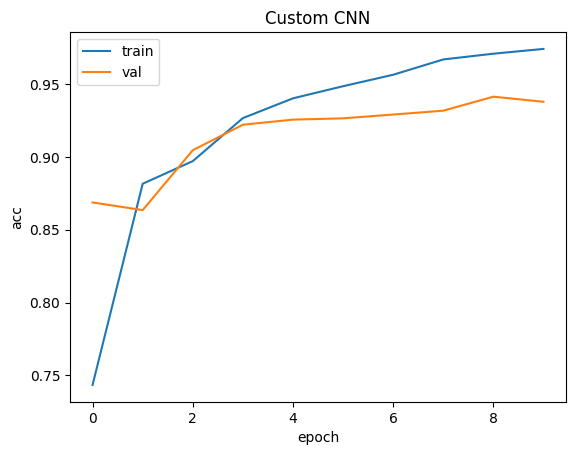

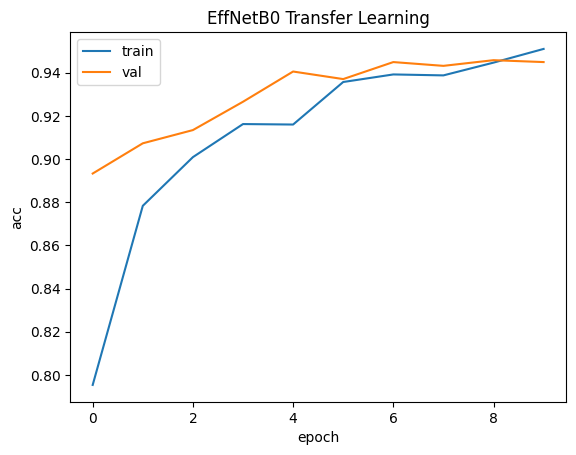

In [18]:
def plot_hist(h, title):
    plt.plot(h.history['accuracy'],label='train')
    plt.plot(h.history['val_accuracy'],label='val')
    plt.title(title); plt.xlabel('epoch'); plt.ylabel('acc')
    plt.legend(); plt.show()

plot_hist(cnn_hist, "Custom CNN") 
plot_hist(tl_hist,  "EffNetB0 Transfer Learning")


### **Block 12: Confusion Matrices**
What it does:

For each model, displays a matrix of true vs. predicted labels, revealing which classes get confused.
Why it matters:

You can point out specific confusions (e.g. meningioma ↔ pituitary) and hypothesize why.

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


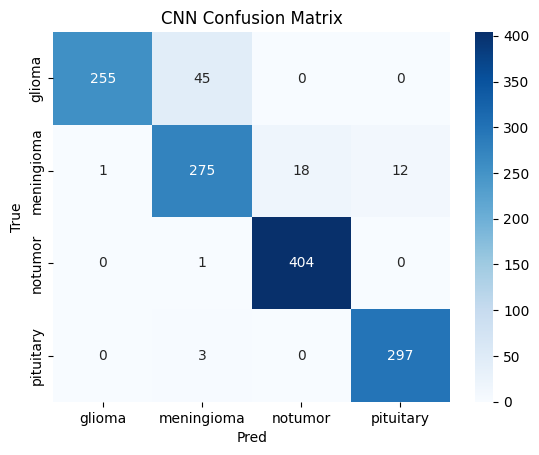

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step


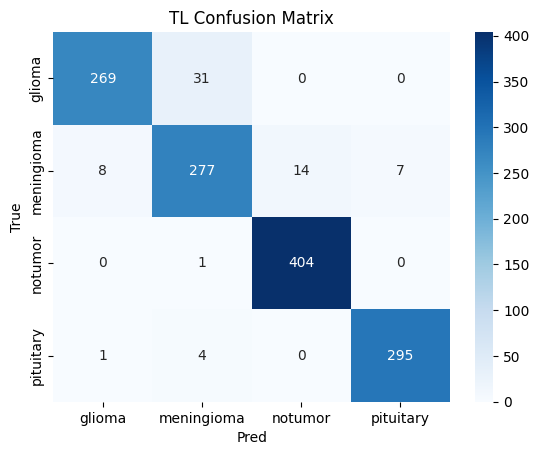

In [19]:
def show_cm(model,X,y, name):
    preds = model.predict(X)
    cm    = confusion_matrix(y.argmax(1), preds.argmax(1))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
                xticklabels=CLASSES,yticklabels=CLASSES)
    plt.title(name); plt.xlabel('Pred'); plt.ylabel('True')
    plt.show()

show_cm(cnn,   X_cnn_test, y_cnn_test, "CNN Confusion Matrix")
show_cm(tl_model,X_tl_test,y_tl_test, "TL Confusion Matrix")


### **Block 13: Show Misclassified Examples**
What it does:

Displays the first three mistakes per true class, so you can inspect border-line cases or data noise.
Why it matters:

Perfect fodder for questions like “What kinds of tumors are hardest to tell apart?” or “How might we handle label noise?”

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


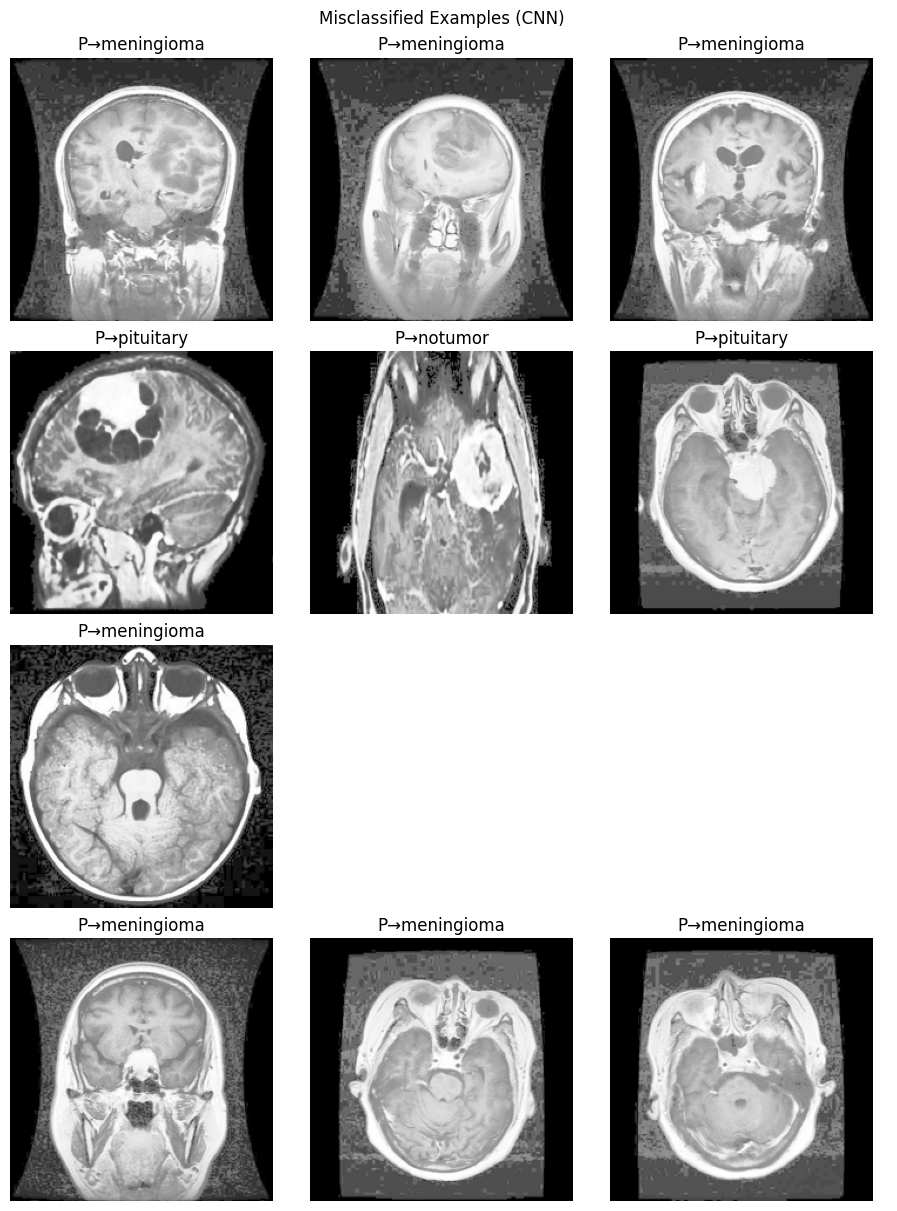

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

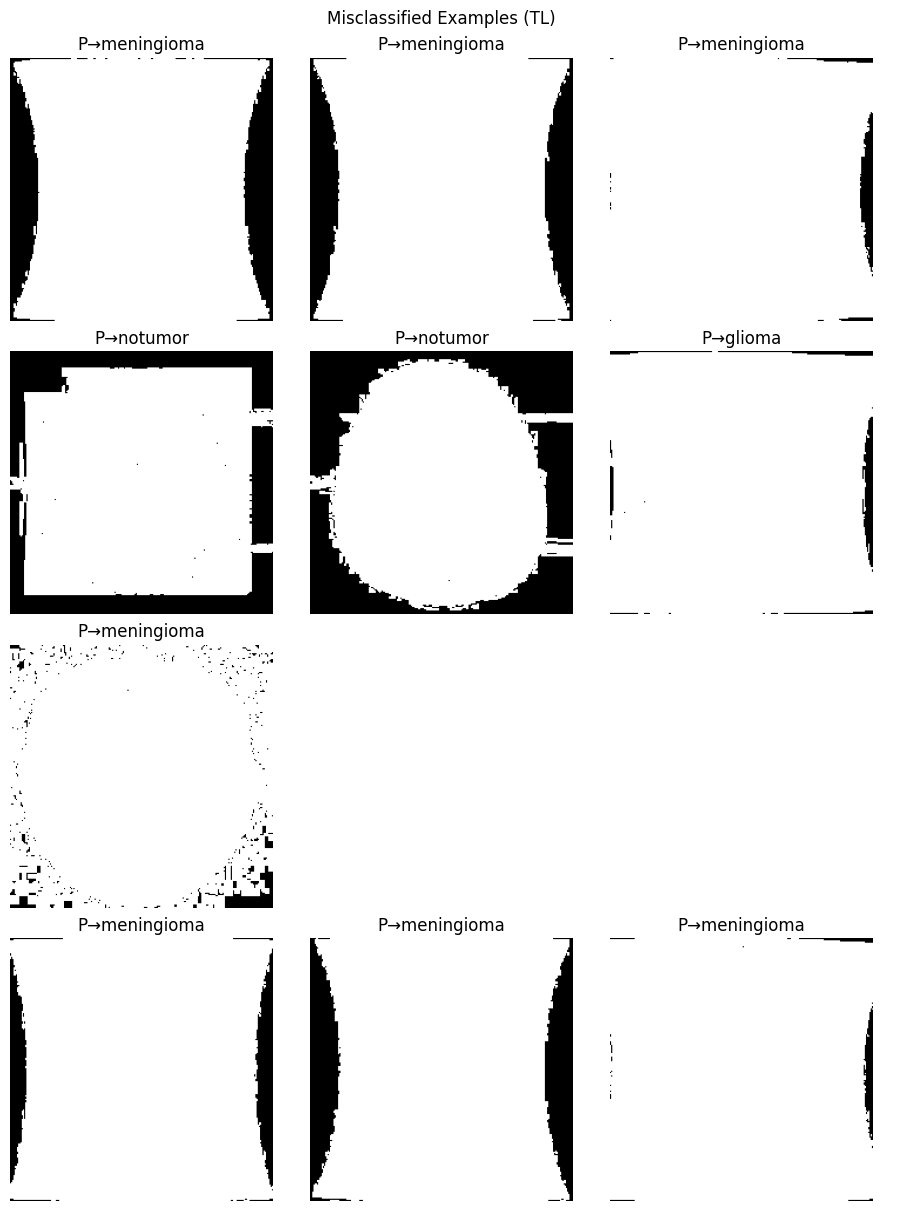

In [20]:
def show_mis(model,X,y, pipeline):
    preds = model.predict(X).argmax(1)
    true  = y.argmax(1)
    mis   = np.where(preds!=true)[0]
    fig,axes = plt.subplots(len(CLASSES),3, figsize=(9,12), constrained_layout=True)
    for i,cls in enumerate(CLASSES):
        cls_mis = mis[true[mis]==i]
        for j in range(3):
            ax = axes[i,j]
            ax.axis('off')
            if j<len(cls_mis):
                img = X[cls_mis[j]]
                if pipeline=='cnn': img = img.squeeze()
                axes[i,j].imshow(img, cmap=('gray' if pipeline=='cnn' else None))
                ax.set_title(f"P→{CLASSES[preds[cls_mis[j]]]}")    
        axes[i,0].set_ylabel(cls,rotation=0,va='center')
    plt.suptitle(f"Misclassified Examples ({pipeline.upper()})")
    plt.show()

show_mis(cnn,   X_cnn_test, y_cnn_test, 'cnn')
show_mis(tl_model,X_tl_test,y_tl_test,'tl')


### **Block 14 (Extra): INTERACTIVE SINGLE-IMAGE PREDICTION FOR TRANSFER-LEARNING MODEL**

In [26]:
# 14) INTERACTIVE SINGLE-IMAGE PREDICTION FOR TRANSFER-LEARNING MODEL

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import ImageOps
import numpy as np

def interactive_predict_tl(model, img_size, class_names):
    """
    Prompts the user for an image file path, then prints the predicted
    tumor type and its probability.
    """
    img_path = input("Enter path to MRI image: ").strip()
    # 1) Load as grayscale and equalize histogram
    pil = load_img(img_path, color_mode="grayscale")
    eq  = ImageOps.equalize(pil).resize(img_size)
    # 2) Convert to array and stack into 3 channels
    arr = img_to_array(eq)[..., 0]            # shape (H, W)
    rgb = np.stack([arr, arr, arr], axis=-1)  # shape (H, W, 3)
    # 3) Preprocess for EfficientNetB0
    x = effnet_preprocess(rgb)                
    x = np.expand_dims(x, axis=0)             # shape (1, H, W, 3)
    # 4) Predict and find top class
    preds = model.predict(x)[0]               
    idx   = np.argmax(preds)                  
    # 5) Print result
    print(f"\nPredicted tumor: {class_names[idx]} ({preds[idx]*100:.2f}%)\n")

# To use:
# interactive_predict_tl(tl_model, IMG_SIZE, CLASSES)


In [32]:
# Make sure classify_image(...) is defined above and tl_model is in memory

# 1) Prompt for a file path and classify
img_path = input("Enter full path to your MRI image: ")
idx, preds = classify_image(img_path, tl_model)

# 2) Print just the top-prediction as a one-liner
print(f"Predicted tumor: {CLASSES[idx]} ({preds[idx]*100:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input: /Users/Phillip/Downloads/Te-me_0019.jpg
  glioma      :  0.03%
  meningioma  : 79.52%
  notumor     :  6.82%
  pituitary   : 13.63%
→ Predicted class: meningioma (79.52%)

Predicted tumor: meningioma (79.52%)
